In [30]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
import numpy as np
from tqdm import tqdm
from warnings import warn

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from aif360.algorithms.postprocessing.reject_option_classification import RejectOptionClassification
from common_utils import compute_metrics
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from aif360.algorithms.postprocessing.eq_odds_postprocessing import EqOddsPostprocessing

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider

from random import shuffle

import pandas as pd

from aif360.algorithms.postprocessing.subgroup_fair\
        import SubgroupFairness

from aif360.algorithms.postprocessing.instantaneous_fair\
        import InstantaneousFairness

import matplotlib.pyplot as plt
import matplotlib.text as mtext
import plotly.express as px
import plotly.graph_objects as go
import random
        
import time

In [31]:
def perf_measure(y_actual, y_hat):
    TP = 0
    TN = 0
    FP = 0 
    FN = 0 
    
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==0:
            TP += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==1:
            TN += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FN += 1

    NR =(TN+FN)/len(y_hat) 
    FPR=FP/(FP+TN+10**(-6)) 
    FNR=FN/(FN+TP+10**(-6))
    PPV=TP/(TP+FP+10**(-6)) 
    NPV=TN/(TN+FN+10**(-6)) 
    inACC=FP+FN 
    
    return [NR,FPR,FNR,PPV,NPV,inACC]

In [32]:
def fair_metric(Dtest, I0_indices, I1_indices, score_name, thresh, base_rate, perf_field):
    I0_mask = Dtest.index.isin(I0_indices)
    I1_mask = Dtest.index.isin(I1_indices)

    if len(base_rate) != 0:
        th0 = np.percentile(Dtest[score_name], [base_rate[0]])[0]
        th1 = np.percentile(Dtest[score_name], [base_rate[1]])[0]
    else:
        th0 = np.percentile(Dtest[score_name], [thresh])[0]
        th1 = th0

    y_actual_I0 = Dtest.loc[I0_mask, perf_field].tolist()
    y_hat_I0 = (Dtest.loc[I0_mask, score_name] >= th0).astype(int).tolist()

    y_actual_I1 = Dtest.loc[I1_mask, perf_field].tolist()
    y_hat_I1 = (Dtest.loc[I1_mask, score_name] >= th1).astype(int).tolist()

    perf_I0 = perf_measure(y_actual_I0, y_hat_I0)
    perf_I1 = perf_measure(y_actual_I1, y_hat_I1)

    IND = abs(perf_I0[0] - perf_I1[0])
    SP = abs(perf_I0[1] - perf_I1[1] + abs(perf_I1[2] - perf_I0[2]))
    SF = abs(perf_I0[3] - perf_I1[3] + abs(perf_I0[4] - perf_I1[4]))
    INA = (perf_I0[5] + perf_I1[5]) / (len(I0_mask) + len(I1_mask))

    return [IND, SP, SF, INA]

In [33]:
def compas_pred(test, train):
  Strain = train
  Strain_pred = np.array([[1-i/10] for i in Strain.convert_to_dataframe()[0]['decile_score'].tolist()])
  Stest = test
  Stest_pred = np.array([[1-i/10] for i in Stest.convert_to_dataframe()[0]['decile_score'].tolist()])
  return Strain, Strain_pred, Stest, Stest_pred

In [34]:
def process_method(m, dataset_filtered_valid, dataset_filtered_valid_pred, Dtest, dataset_length, dataset_filtered):
    pp = method_initializers[m](privileged_groups, unprivileged_groups)
    if m == 'subgroup-fair' or m == 'instantaneous-fair':
        pp.set_optimisation_parameters(
            predictCol="two_year_recid",
                    attr1="age", 
                    attr2="priors_total_count", 
                    attr3="decile_score",
                    solver="sdpa",
                    solver_parameters={"executable":"sdpa_gmp","executable": "C:\\Users\\01joh\\OneDrive\\Desktop\\sdpa7-windows\\sdpa.exe"}
        )

        pp_fit = pp.fit(dataset_filtered_valid, dataset_filtered_valid_pred)
        pp_scores = pp.predict(dataset_filtered_valid_pred).scores
    else:
        Strain, Strain_pred, Stest, Stest_pred = compas_pred(dataset_filtered_valid_pred,dataset_filtered_valid_pred)
        print("Fitting using method: ", m)
        pp.fit(Strain, Strain_pred)
        print("Predicting using method: ", m)
        pp_scores = pp.predict(Stest_pred).scores

    score_indices = Dtest.index  # Adjust to use DataFrame indices directly
    i = 0
    for j in score_indices:
        Dtest.at[j, m] = pp_scores[i]
        i += 1

In [35]:
def run_trials(trials, methods, dataset_filtered, protected_attribute_used, perf_field, thresh=[]):
    # To store the performance metrics for each trial and method
    metric_rows = [] 
    # To store the runtime of each method for each trial
    metric_runtimes = [] 


    for t in tqdm(range(trials)):
        # Setting a fixed seed for reproducibility in random operations.
        # t is used so that the shuffle is different for each trial, but the results are reproducible.
        np.random.seed(t)

        # Splitting the dataset into training and validation/test sets with a 70-30 split.
        # This split is randomized due to the 'shuffle=True' parameter,
        # So that the results are not biased by the order of the dataset. This is why
        # multiple trials are performed to get a more accurate representation of the results.
        dataset_filtered_train, dataset_filtered_vt = dataset_filtered.split([0.7], shuffle=True)
        # Further splitting the 30% validation/test set into two equal parts for validation and testing.
        dataset_filtered_valid, dataset_filtered_test = dataset_filtered_vt.split([0.5], shuffle=True)
        dataset_filtered_valid_pred = dataset_filtered_valid.copy(deepcopy=True)
        dataset_length = len(dataset_filtered_valid_pred.convert_to_dataframe()[0].index.tolist())
        
        dataset_filtered_valid_priv = dataset_filtered_valid_pred.convert_to_dataframe()[0][dataset_filtered_valid_pred.convert_to_dataframe()[0][protected_attribute_used] == 1]
        dataset_filtered_valid_unpriv = dataset_filtered_valid_pred.convert_to_dataframe()[0][dataset_filtered_valid_pred.convert_to_dataframe()[0][protected_attribute_used] == 0]


        # Preparing the test dataset
        Dtest = dataset_filtered_valid_pred.convert_to_dataframe()[0]
        for m in methods:
            time1 = time.time()
            process_method(m, dataset_filtered_valid, dataset_filtered_valid_pred, Dtest, dataset_length, dataset_filtered)
            time2 = time.time()
            metric_runtimes.append({'method': m, 'runtime': time2 - time1, 'trial': t})

        # Calculating the base rates for fairness metrics
        base0,base1 = SubgroupFairness(privileged_groups,unprivileged_groups).base_rate(dataset_filtered.convert_to_dataframe()[0], perf_field, protected_attribute_used)
            
        # Ensuring equal representation by downsampling
        len_rw = min(len(dataset_filtered_valid_priv), len(dataset_filtered_valid_unpriv))
        # Downsampling the privileged group
        dataset_filtered_valid_priv_rw = dataset_filtered_valid_priv.sample(n=len_rw, random_state=1)
        # Downsampling the unprivileged group
        dataset_filtered_valid_unpriv_rw = dataset_filtered_valid_unpriv.sample(n=len_rw, random_state=1)
        # Combined downsampled dataset for fairness evaluation
        Dtest_rw = pd.concat([dataset_filtered_valid_priv_rw, dataset_filtered_valid_unpriv_rw])

        if thresh != []:
            thresh = [0.5]
        for threshhold in thresh:
            for m in methods:
                # Evaluating model performance and fairness metrics before and after reweighing
                model_perf = fair_metric(Dtest, dataset_filtered_valid_priv.index, dataset_filtered_valid_unpriv.index, m, thresh, [base0, base1], perf_field)
                model_perf_rw = fair_metric(Dtest, dataset_filtered_valid_priv_rw.index, dataset_filtered_valid_unpriv_rw.index, m, thresh, [base0, base1], perf_field)
                # Storing the performance metrics
                new_row = {'IND': model_perf[0], 'SP': model_perf[1], 'SF': model_perf[2], 'INA': model_perf[3],
                    'INDrw': model_perf_rw[0], 'SPrw': model_perf_rw[1], 'SFrw': model_perf_rw[2], 'INArw': model_perf_rw[3],
                    'type': m, 'thresh': threshhold, 'trial': t} 
                metric_rows.append(new_row)

    # Convert the collected metrics into a DataFrame for analysis and reporting
    metric = pd.DataFrame(metric_rows)
    metric_runtime = pd.DataFrame(metric_runtimes)
    return metric, metric_runtime

In [36]:
dataset_used = "compas" # "adult", "german", "compas"
protected_attribute_used = 'race'
privileged_groups = [{protected_attribute_used: 1}]
unprivileged_groups = [{protected_attribute_used: 0}]
predictor_attribute = 'decile_score'

attr1 = "age"
attr2 = "priors_total_count"
attr3 = "decile_score"

# Dataset loaders are mapped to their respective functions for easy access.
# This dictionary helps in dynamically loading the dataset based on a string identifier.
dataset_loaders = {
    "adult": load_preproc_data_adult,
    "german": load_preproc_data_german,
    "compas": load_preproc_data_compas
}

# Similar to dataset loaders, method initializers are mapped to their respective classes.
# This allows for the dynamic initialization of fairness methods based on a string identifier.
method_initializers = {
    "reject-object-classification": RejectOptionClassification,
    "eq-odds-postprocessing": EqOddsPostprocessing,
    "subgroup-fair": SubgroupFairness,
    "instantaneous-fair": InstantaneousFairness
}

# Load the dataset using the loader corresponding to the selected dataset.
# The selected dataset and protected attribute are used here.
dataset_orig = dataset_loaders[dataset_used]([protected_attribute_used])
if dataset_used == "compas":
    perf_field = "two_year_recid"

dataset_filtered = dataset_orig.copy()

# Number of trials to perform
trials = 10
# List of methods to be tested
methods = [#'reject-object-classification', 
            #'eq-odds-postprocessing', 
            'subgroup-fair', 
            'instantaneous-fair']
    


Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [37]:
metric_results, runtime_results = run_trials(trials, methods, dataset_filtered, protected_attribute_used, perf_field, thresh=[0.5])

100%|██████████| 10/10 [01:35<00:00,  9.51s/it]


In [38]:
metric_results.head()

,IND,SP,SF,INA,INDrw,SPrw,SFrw,INArw,type,thresh,trial
0,0.114450,0.217421,0.221006,0.238636,0.110749,0.210174,0.214388,0.184343,subgroup-fair,0.5,0
1,0.137406,0.278677,0.235826,0.246212,0.146580,0.298125,0.229166,0.192551,instantaneous-fair,0.5,0
2,0.331428,0.659835,0.213461,0.236742,0.335443,0.669918,0.238048,0.190657,subgroup-fair,0.5,1
3,0.200324,0.396085,0.213798,0.240530,0.199367,0.389912,0.227551,0.187500,instantaneous-fair,0.5,1
4,0.114994,0.218389,0.238642,0.230429,0.118971,0.229451,0.200465,0.178030,subgroup-fair,0.5,2


In [39]:
runtime_results.head(len(methods))

,method,runtime,trial
0,subgroup-fair,5.901578,0
1,instantaneous-fair,3.196249,0


The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
The provided callable <function mean at 0x000002127F2C41F0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
The provided callable <function std at 0x000002127F2C43A0> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.


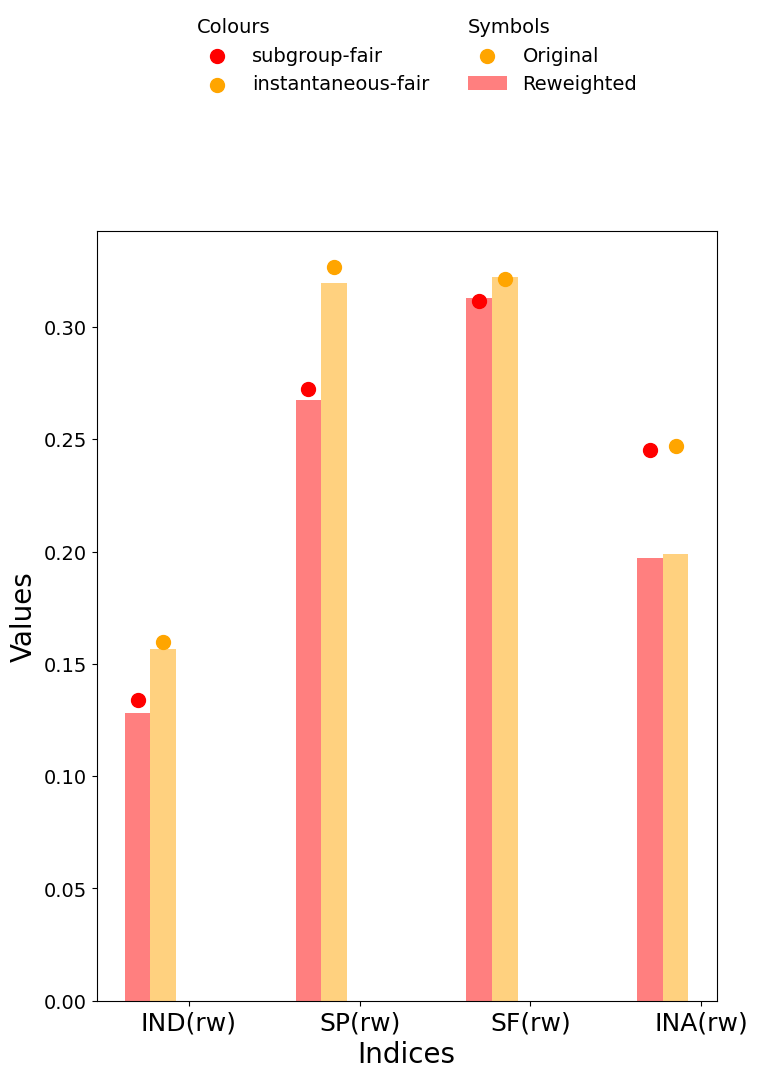

In [40]:
class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, orig_handle,  **self.text_props)
        handlebox.add_artist(title)
        return title

performance = ['IND','SP','SF','INA']
performance1 = np.array([[i,i+'rw'] for i in performance]).flatten().tolist()
performance2 = np.array([[i+'rw'] for i in performance]).flatten().tolist()
metric_results[['type','thresh','trial']] = metric_results[['type','thresh','trial']].astype("category")
colors=['r','orange','c','g','b','m','y','k']

pivot=pd.pivot_table(metric_results,index=['type','thresh'],values=performance1,aggfunc=[np.mean,np.std])

ind=np.arange(4)
width = 0.15

fig, ax1 = plt.subplots(figsize=(8,10))

i=0
for m in methods:
    sub=[pivot[('mean',p+'rw')][(m,0.5)] for p in performance]
    sub1=[pivot[('mean',p)][(m,0.5)] for p in performance]
    ax1.bar(ind+width*i,sub,width, alpha=0.5,color=colors[i],label=m) #,label=m
    #ax1.scatter(ind+width*i,sub, marker='s',color=colors[i],label=m) #,label=m
    ax1.scatter(ind+width*i,sub1, marker='o',s=100,color=colors[i],label=m)
    i+=1

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(['Colours'] + handles[:(len(methods))] + ['']+ ['Symbols'] + handles[(len(methods)-1):(len(methods)+1)] +[' '],
          [''] + labels[:len(methods)] + [''] + [''] + ['Original','Reweighted']+[' '],
           handler_map={str: LegendTitle({'fontsize': 14})},
          bbox_to_anchor=(0.9,1.3), fontsize=14,frameon=False,ncol=2
        )

#ax1.legend(loc='upper left',fontsize=14)
ax1.set_xlabel('Indices', fontsize=20)
ax1.set_ylabel('Values', fontsize=20)

ax1.set_xticks(ind+2*width)
ax1.set_xticklabels([i+'(rw)' for i in performance], fontsize=18)
ax1.tick_params(axis='y', which='major', labelsize=14)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.show()

The provided callable <function mean at 0x000002127F2C41F0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
The provided callable <function std at 0x000002127F2C43A0> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.


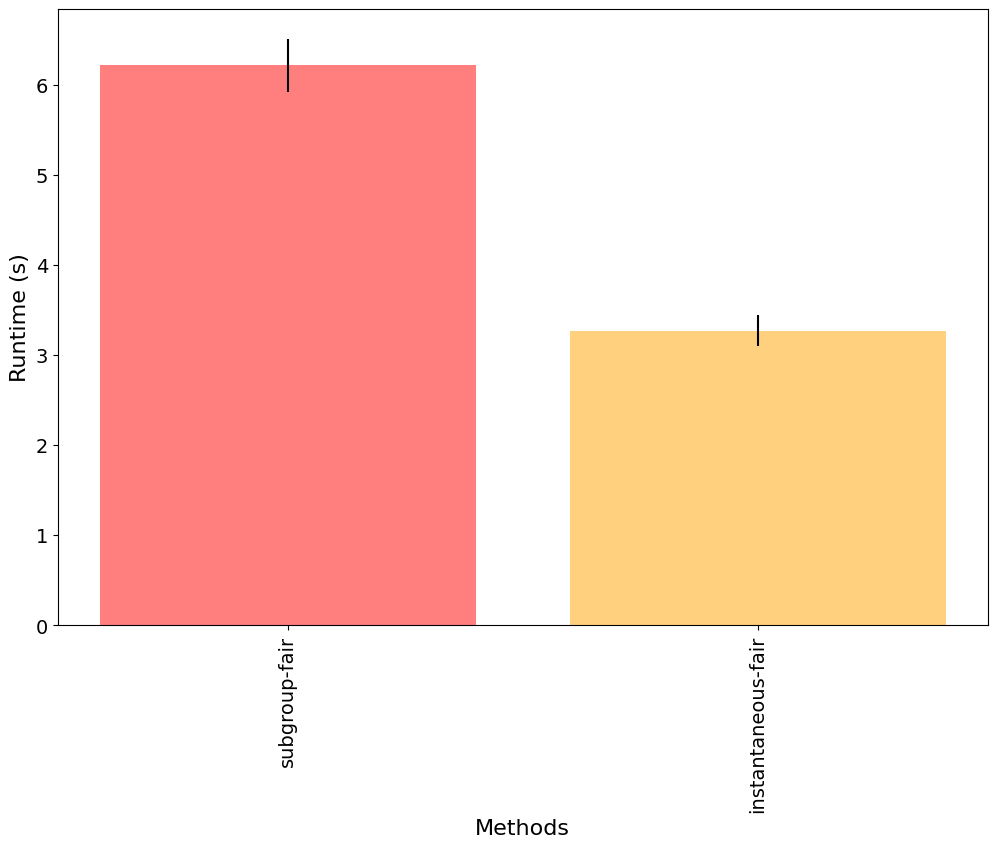

In [41]:
pivot_runtime=pd.pivot_table(runtime_results,index=['method'],values=['runtime'],aggfunc=[np.mean,np.std])

fig, ax1 = plt.subplots(figsize=(12,8))


sub=[pivot_runtime[('mean','runtime')][m] for m in methods]
sub1=[pivot_runtime[('std','runtime')][m] for m in methods]
ax1.bar(methods,sub,yerr=sub1,alpha=0.5,color=colors[:len(methods)]) #,label=m
ax1.set_xlabel('Methods', fontsize=16)
ax1.set_ylabel('Runtime (s)', fontsize=16)
ax1.tick_params(axis='y', which='major', labelsize=14)
ax1.tick_params(axis='x', which='major', labelsize=14, rotation=90)

plt.show()